In [1]:
import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
importlib.reload(function)
from function import csv_to_stardata,calc_dist,calc_theta,rotate_point,match_points,equator_calc_near_dot,calc_edge_list

In [2]:
def csv_to_human_test_data(filename):
    df=pd.read_csv(filename)

    names=df['name'].values
    x=df['x'].values
    y=df['y'].values
    p=df['p'].values
    position=np.column_stack((x,y))
    idx_Lsho=np.where(names=='L_shoulder')[0][0]
    idx_Rsho=np.where(names=='R_shoulder')[0][0]
    neck_position=(position[idx_Lsho]+position[idx_Rsho])/2

    idx_Lwai=np.where(names=='L_waist')[0][0]
    idx_Rwai=np.where(names=='R_waist')[0][0]
    stomach_position=(position[idx_Lwai]+position[idx_Rwai])/2

    new_name=np.array(['Neck','Stomach'])
    new_position=np.array([neck_position,stomach_position])
    names=np.concatenate((new_name,names))
    position=np.vstack((new_position,position))
    
    return names,position

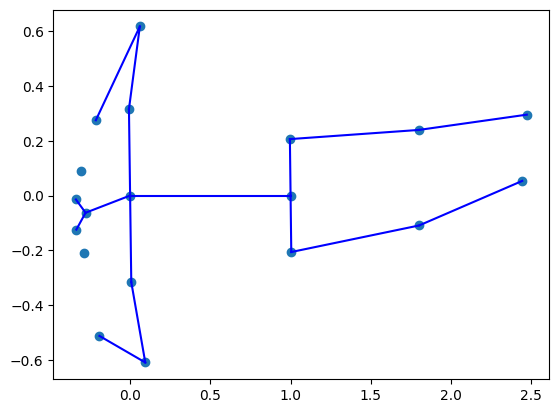

In [3]:
names,points=csv_to_human_test_data('../point_data/human_test/test_csv/person7.csv')
p=len(points)

point_edge_list=[(0,1),(0,2),(0,7),(0,8),(1,13),(1,14),(2,3),(2,4),(7,9),(8,10),(9,11),(10,12),(13,15),(14,16),(15,17),(16,18)]

for i in range(1,p):
    points[i]=points[i]-points[0]
points[0]=np.array([0,0])
norm=np.linalg.norm(points[1])
theta=calc_theta(points[1])
for i  in range(1,p):
    points[i]=rotate_point(points[i]/norm,(-1)*theta)

plt.scatter(points[:,0],points[:,1])
for edge in point_edge_list:
    p1=points[edge[0]]
    p2=points[edge[1]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')

In [9]:
x,y,lum,HIPnum=csv_to_stardata('../star_data/equator.csv')
data = np.column_stack((x,y,lum,HIPnum))

ex_data=[]
for i in range(len(x)):
    if x[i]>3:
        ex_data.append(data[i])

ex_data=np.array(ex_data)

x,y,lum,HIPnum=csv_to_stardata('../star_data/ex_equator.csv')
extra_data = np.column_stack((x,y,lum,HIPnum))

ex_data=np.vstack((ex_data,extra_data))

x=ex_data[:,0]
y=ex_data[:,1]
lum=ex_data[:,2]
HIPnum=ex_data[:,3]
size=7*np.exp(-1*(lum+2)*np.log(2))


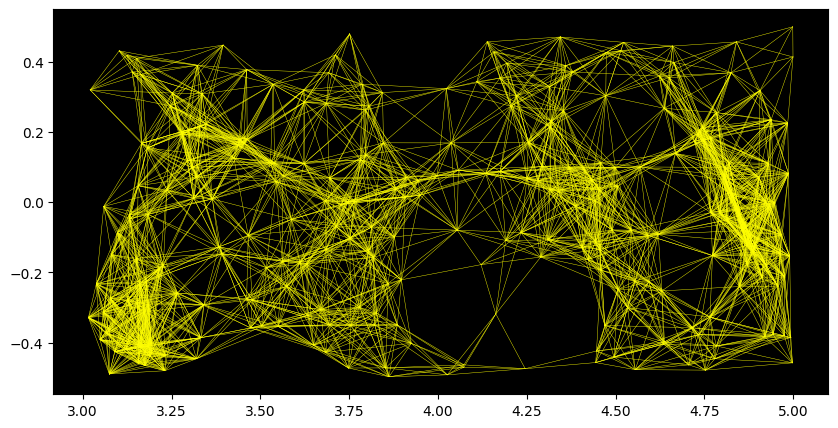

In [19]:
edge_list=calc_edge_list(x,y,HIPnum,0,0.25)
fig, ax = plt.subplots(figsize=(10,5))
ax.patch.set_facecolor('black')
for edge in edge_list:
    node1,node2=edge
    x1,y1,=x[node1],y[node1]
    indice2=np.where(HIPnum==node2)
    x2,y2=x[node2],y[node2]
    plt.plot((x1,x2),(y1,y2),linewidth=0.3,color='yellow')
plt.show()
size=7*np.exp(-1*(lum+2)*np.log(2))


In [13]:
dotsize_x=200
dotsize_y=100

a_x=(x-3)*100
a_y=(y+0.5)*100

reshaped_position=np.column_stack((a_x,a_y))
points_size=len(points)
penalty_of_size=8*np.exp(-5*size*np.log(2)-1)

min_dist=float('inf')
min_stars=[-1 for _ in range(points_size)]
min_apoints=0

#a_starsはreshapedpositionでいい
a_stars=np.column_stack((a_x,a_y))

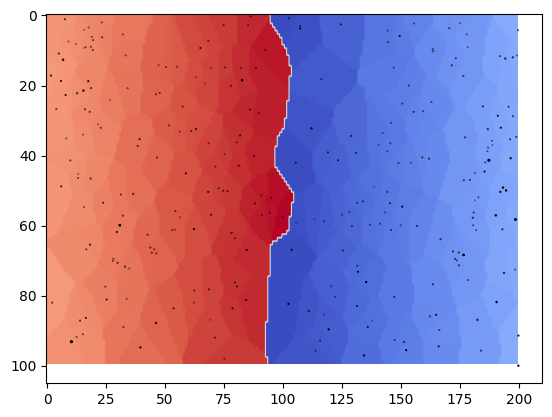

In [15]:
near_dot=equator_calc_near_dot(reshaped_position,dotsize_x,dotsize_y,HIPnum)

plt.imshow(near_dot, cmap='coolwarm', aspect='auto')
plt.scatter(a_x,a_y,s=size,color='black')
plt.show()

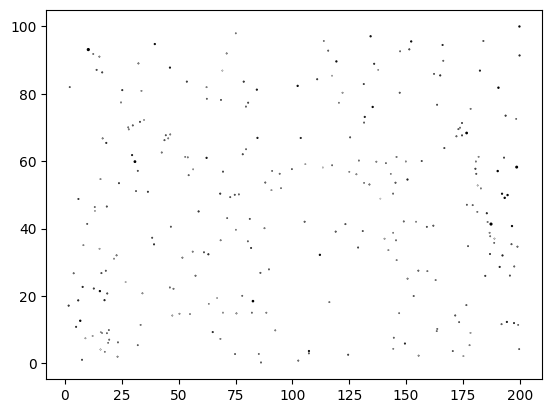

In [16]:
plt.scatter(a_x,a_y,s=size,color='black')
plt.show()

In [20]:
for edge in edge_list:
    node1,node2=edge
    star_1=reshaped_position[node1]
    star_2=reshaped_position[node2]
    norm=np.linalg.norm(star_2-star_1)
    theta=calc_theta(star_2-star_1)
    a_points=match_points(points,norm,theta,star_1)
    near_stars=[-1 for _ in range(points_size)]
    dist=0
    for i in range(points_size):
        a_point=a_points[i]
        a_point_x=int(round(a_point[0],0))
        a_point_y=int(round(a_point[1],0))
        #ここの処理は変えたほうがいいかも
        if a_point_x<0 or a_point_x>=dotsize_x or a_point_y<0 or a_point_y>=dotsize_y:
            break
        indice3=np.where(HIPnum==near_dot[a_point_y][a_point_x])[0][0]
        nearest_star=np.array([a_x[indice3],a_y[indice3]]).reshape(-1)
        dist+=np.sum((a_point-nearest_star)**2)/(norm**(2))
        near_stars[i]=indice3
        if dist>min_dist:
            break
        if i==points_size-1:
            shape_penalty_rate=0
            
            for j in range(points_size):
                shape_penalty_rate+=penalty_of_size[near_stars[j]]
                for k in range(j+1,points_size):
                    if near_stars[j]==near_stars[k]:
                        if (j,k) in edge_list:
                            shape_penalty_rate+=1.5
                        else:
                            shape_penalty_rate+=0.3
            dist=dist*(1+shape_penalty_rate)
            dist+=norm*points_size/100
            if dist>min_dist:
                break
            min_dist=dist 
            min_stars=near_stars
            min_a_points=a_points
        if dist>min_dist:
            break
print(min_dist)
print(min_stars)
print(min_a_points)
            

15.262172519816591
[26, 40, 23, 30, 23, 30, 23, 42, 6, 53, 0, 41, 10, 40, 20, 52, 43, 49, 48]
[[15.74074074  9.27021605]
 [22.68518519 32.0525    ]
 [15.2411848   2.51286716]
 [16.24032946  0.77751928]
 [13.71927579  1.47350986]
 [18.53556862  1.22914828]
 [11.57251155  2.98304324]
 [22.98374346  7.24256327]
 [ 8.49773802 11.29786883]
 [30.26850168  7.1961792 ]
 [ 2.1100336  14.93250087]
 [26.07397835  1.35599042]
 [ 7.99972494  6.30834977]
 [27.40713423 30.7208378 ]
 [17.96323614 33.3841622 ]
 [30.732408   49.54367007]
 [22.78258191 51.92550596]
 [31.49332973 65.31339438]
 [26.18519524 67.63955627]]


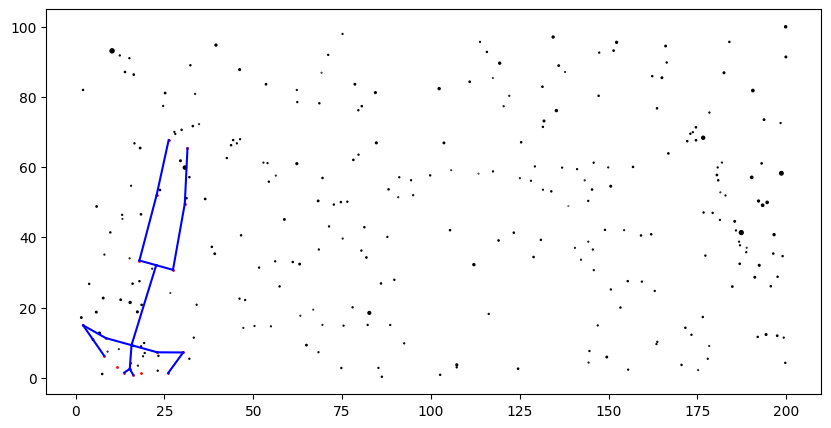

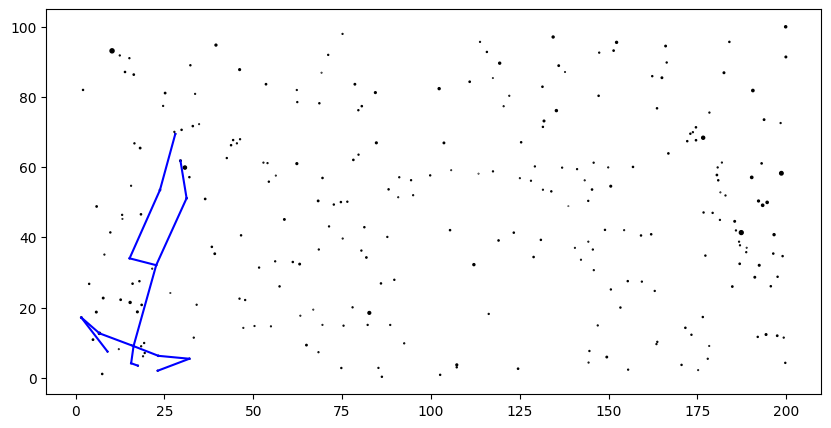

In [22]:
near_dot=np.array(near_dot)
plt.figure(figsize=(10, 5))
plt.scatter(a_x,a_y,color='black',s=size*5)
plt.scatter(min_a_points[:,0],min_a_points[:,1],color='red',s=1)
for edge in point_edge_list:
    p1=min_a_points[edge[0]]
    p2=min_a_points[edge[1]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(a_x,a_y,color='black',s=size*5)
for edge in point_edge_list:
    p1=a_stars[min_stars[edge[0]]]
    p2=a_stars[min_stars[edge[1]]]
    plt.plot((p1[0],p2[0]),(p1[1],p2[1]),color='blue')
plt.show()